## ライブラリの読み込み

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import math
import statistics
import os
import datetime
import csv

## "個体"クラス

### コンストラクタ
・性別はランダム(0.5)で決定<br>
・遺伝/非遺伝クラスに引数「genome」の値を渡す<br>
・遺伝クラスのメソッド"maturityCalc"で精子の長さから成熟までの長さを決定、<br>メソッド"produceSpermVolume"で1tickで作る精子の数を計算し、その結果を非遺伝クラスにわたす。<br>
### deathメソッド
個体は60tickで死ぬ。60歳であるならば0を返す。<br>
また、1/60の確率で0を返す。<br>
D. melanogaster の寿命を参考にして決定。<br>
(V.1.6: 100tick から 60tickへ)
### spermVSsrメソッド
生殖のときに呼び出すメソッド。<br>
精子の長さがSRより長い場合、おそらく違いを認識できないという理由から"SRの長さ"をその"精子の長さ"として扱う。<br>

### spawning(産卵)メソッド
生殖のときに呼び出すメソッド。<br>
2匹の雄の精子が入っている場合、長い方の精子を優先的に使う。<br>
返り値としてはspermUse()の結果を返す。
### spermUseメソッド
引数jの回数だけ繰り返してk番目の雄の精子を1つずつ消費してnextGen関数で次世代の形質を決定する。<br>
もし残り精子が1個未満になった場合、その雄の情報ごと削除する。
### tickメソッド
これを毎回外部から実行させる。<br>
1歳年をとらせ、spawningメソッドを実行、もし返り値があるならばその情報を返す。

In [2]:
class Indivisual():
    def __init__(self, genome):
        self.sex = random.choice(["m", "f"])
        self.heritable = Heritable(*genome)
        self.nonheritable = Nonheritable(*genome)
        self.eggnum = self.eggcalc()
        self.nonheritable.sex = self.sex
        
    def death(self): # 死亡処理(0が死，1が生を意味する)
        if self.nonheritable.age == 60: # 60歳で必ず死ぬ
            return 0
        else:
            return np.random.choice([0, 1], p=[(1/60), (59/60)]) # 1/60の確率で死ぬ

    def spermVSsr(self, spermlen):
        if self.nonheritable.srlen*0.9 < spermlen: # 精子の長さのほうがSRより長かったらSRを精子の長さにする
            return self.nonheritable.srlen
        else:
            return spermlen 
                
    def spawning(self):
        if self.sex == "f" and len(self.nonheritable.spermstlen) != 0: # 精子を持っている雌 
#            self.eggnum = 2
            maxlen = 0
            maxindex = 0
            for i in self.nonheritable.spermstlen[:]:
                if i[2] < 1:
                    index = self.nonheritable.spermstlen.index(i)
                    del self.nonheritable.spermstlen[index]
            
            for i in range(len(self.nonheritable.spermstlen)): # 1つずつ比較しmaxを求める
                falen = self.spermVSsr(self.nonheritable.spermstlen[i][1])
                if maxlen <= falen: # 新しい精子のほうが同じ長さなら有利
                    maxlen = falen
                    maxindex = i
            if self.nonheritable.spermstlen[maxindex][2] >= self.eggnum:
                return self.spermUse(self.eggnum, maxindex)
            elif self.nonheritable.copflag != 0:
                del self.nonheritable.spermstlen[maxindex]

                    
    def spermUse(self, j, k):
        egg = []
        for i in range(j):

            self.nonheritable.spermstlen[k][2] = self.nonheritable.spermstlen[k][2] - 1 # 1つ精子を使用
            egg.append(nextGen(self.heritable, self.nonheritable.spermstlen[k][0])) # 次世代の形質決定
            if self.nonheritable.spermstlen[k][2] < 1:
                del self.nonheritable.spermstlen[k]
                break
        return egg                   
   
    def eggcalc(self):
        a = math.floor(2*self.nonheritable.health)
        if a < 1:
            a = 1
        return a
        
            

    def tick(self):
        self.nonheritable.aging()
        spawn = self.spawning()
        if spawn is not None:
            return spawn
    

## 遺伝クラス
ここでは主にその世代において変化しない形質の情報に関するメソッドがある。

### コンストラクタ
受け取った情報を格納するだけ。<br>
(V.1.7: thoraxを削除)
### maturityCalcメソッド
オスについてはScorr PITNICK et al(1995)を元に式を導き出し、計算。<br>
幼虫・蛹期間は10という仮定。<br>
メスは10で固定。羽化直後すぐ卵を産める<br>
### produceSpermVolumeメソッド
S. pitnick(1996)を参考に作成。<br>
あんまりこの式に意味を感じてない。変更予定。

In [3]:
class Heritable():
    def __init__(self, spermlen, srlen, health):
        self.spermlen = spermlen
        self.srlen = srlen
        self.health = health

    def maturityCalc(self, sex):
        if sex == "f":
            #return (np.power(self.thorax/1000, 5)+10)
            return 10
        else:
            a = self.spermlen * 0.005+1
            if a < 10:
                a = 10
            return a

    def spermVolume(self): # 射精する精子の数
        sv = pow(10, -1.4803* np.log10(self.spermlen) + 8.251)
        #sv = -0.05*self.spermlen+135
        if sv <1:
            sv = 1
        return sv

## 非遺伝クラス
### コンストラクタ
値の収納。
### setMpsvメソッド
外部から呼び出して使う。

In [4]:
class Nonheritable():

    def __init__(self, spermlen, srlen, health):
        # default
        self.maturity = 0    # 成熟するまでの時間
        self.spermvol = 0    # 一度の射精で出す精子の数
        self.age = 0         # 現在の年齢
        self.fertility = 0   # 成熟したか(1で成熟)
        self.spermpos = 0    # 持っている精子の数(雄)
        self.spermstlen = [] # 持っている精子の数とインスタンス(雌)
        self.coptime = 0     # 交尾した時のage
        self.psv = 0         # 1tickで作る精子の数
        self.copulatable = 0 # 交尾可能か(1で可能)
        self.sex= ""
        self.spermlen = np.random.normal(spermlen, 30) # 環境分散の追加
        self.srlen = np.random.normal(srlen, 30)
        self.health = 1
        self.helcalc(health)

        self.srvol = self.srlen
#        self.srvol = 90        # SRの貯蔵容量
        self.copflag = 0     # 一度交尾したことがあるか
        self.maturityCalc()
        self.spermVolume()
    
    def helcalc(self, health):
        a = np.random.normal(health, 0.5)
        if a < 1:
            a = 1
        elif a >= 5:
            a = 5
            
        self.health = a
    
    def maturityCalc(self):
        if self.sex == "f":
            self.maturity= 10
        else:
            a = self.spermlen * 0.005+1
            if a < 10:
                a = 10
            self.maturity= a

    def spermVolume(self): # 射精する精子の数
        sv = pow(10, -1.4803* np.log10(self.spermlen) + 8.251)
        if sv <1:
            sv = 1
        self.spermvol= sv
    

        spsv = self.spermvol 
        if spsv < 1:
            self.psv = 1
        else:
            self.psv = spsv
    
    def aging(self):
        self.age = self.age + 1
        self.getFertility()
        if self.sex == "m":
            spsv = self.spermvol * (10/self.age) *self.health
            if spsv < 1:
                self.psv = 1
            else:
                self.psv = spsv
            self.spermStore()
        self.checkCopulatable()

        
        
    def spermStore(self):
        if self.fertility == 1:
            self.spermpos = self.spermpos + self.psv

            
    def killSperm(self):
        if len(self.spermstlen) >= 1:
            for i in range(len(self.spermstlen)):
                if self.spermstlen[i][2] <= 1:
                    del self.spermstlen[i]

                
 
    def getFertility(self):
        if self.fertility == 0:
            if self.age >= self.maturity:
                self.fertility = 1
                if self.sex == "f":
                    self.copulatable = 1
        
    def checkCopulatable(self):
        if self.sex == "f":
            if self.coptime != 0: # 一度は交尾したことがある
                self.copflag = 1
                if self.copulatable == 0: # 現在交尾不可能である
                    if self.age >= self.coptime + 4 or len(self.spermstlen) == 0: # 最後の交尾時間から5tick進んでる
                        self.copulatable = 1

        else:
            if self.spermpos >= self.spermvol: # 持っている精子の数が射精量を上回っている
                self.copulatable = 1
            else:
                self.copulatable = 0
    
    def receiveSperm(self, male):
#        if (self.srlen * (0.8)) <= male.heritable.spermlen <= self.srlen * (1.1): # 要検証
#        if male.heritable.spermlen <= self.srlen * (1.2):
            spermcount = 0
            thisvol = 0
            r = [] # 1番目に雄遺伝性インスタンス、2番目に精子長さ、3番目に精子の数
            stindex = []
            stcounter = []
            stratio = []
            delindex = []
            shorispermvol = 0

            for i in range(len(self.spermstlen)):
                stcounter.append(self.spermstlen[i][2])
                stindex.append(i)
            spermcount = sum(stcounter)
            for i in range(len(self.spermstlen)):
                stratio.append(self.spermstlen[i][2]/spermcount)
            shorispermvol = male.nonheritable.spermvol /5
            if self.srvol-spermcount >= shorispermvol: # 空き容量のほうが射精量以上ならそのまま入れる
                receivol = shorispermvol
            else:
                if len(stindex) != 0:
                    sabun = np.ceil(shorispermvol - (self.srvol-spermcount))
                    kesu = np.random.choice(stindex, int(sabun), p=stratio)
                    for i in range(len(stindex)): # 選ばれた数の精子が排出される
                        self.spermstlen[i][2] = self.spermstlen[i][2] - len(np.where(kesu==i)[0])
                        if self.spermstlen[i][2] < 1:
                            delindex.append(i)
                    for i in delindex:
                        del self.spermstlen[i]
                        if len(delindex) > 1:
                            for j in range(len(delindex)):
                                delindex[j] = delindex[j] -1
                    
                receivol = shorispermvol

            r.append(male.heritable)
            r.append(male.nonheritable.spermlen)
            r.append(receivol)

            self.spermstlen.append(r) #末尾に今回のを追加
            self.coptime = self.age
        
    def ejaculation(self):
        self.spermpos = self.spermpos - self.spermvol
        if self.spermpos < self.spermvol:
            self.copulatable = 0

## 個々の関数
### nextGen関数
親2匹の形質から次世代の形質を決定する。<br>
単純に両親の形質の相加平均を元にし、さらに固定数の分散から、正規分布を作る。<br>
その正規分布に従って確率的に次世代の形質を選ぶ。

In [5]:
def nextGen(female, male):
    fH = female
    mH = male

    ave = 0
    SpermAve = 0
    SRAve = 0
    HealthAve = 0
    f = []
    m = []
    nextgen = []

    # 遺伝数値のみを抜き取る
    for i in fH.__dict__.items():
        f.append(i[1])
    for i in mH.__dict__.items():
        m.append(i[1])

    # sperm, SRの算術平均を求める
    SpermAve = (f[0]+m[0])/2
    SRAve = (f[1]+m[1])/2
    HealthAve = (f[2]+m[2])/2
    
    # 平均ave、分散30の正規分布から次世代の値を決定 #2018/12/28：60→30へ変更
    nextgen.append(np.random.normal(SpermAve, 60))
    nextgen.append(np.random.normal(SRAve, 60))
    nextgen.append(np.random.normal(HealthAve, 0.05))

    
    return nextgen

### copulation関数
集団の一部分を取り出し、そこから更に雌雄別々に交配可能な個体を取り出す。<br>
交配可能な雌雄どちらかの数が多い場合、少ない方の数だけ交配を行う。<br>
交配は交配可能な集団のうちから性別ごとにランダムに抽出され、

In [6]:
def copulation(population):
    male_population = []
    female_population = []
    # 計算量抑制のため，集団の1/2のみを選出，そこから交尾可能か探る
#    selected_population = random.sample(population, round(len(population)/1))
    selected_population = population
    for i in range(len(selected_population)):
        if selected_population[i].sex == "f":
            if selected_population[i].nonheritable.copulatable == 1:
                female_population.append(selected_population[i])
                selected_population[i].nonheritable.copulatable = 0
            
        elif selected_population[i].sex == "m" and selected_population[i].nonheritable.copulatable == 1:
            male_population.append(selected_population[i])
            if selected_population[i].nonheritable.spermpos < selected_population[i].nonheritable.spermvol:
                selected_population[i].nonheritable.copulatable = 0

    if len(female_population) >= len(male_population):
        cop_i = len(male_population)
    else:
        cop_i = len(female_population)

    
    for i in range(cop_i): # 交尾させる雌雄の抽出と交配
        cop_female = female_population.pop(random.randrange(len(female_population)))
        cop_male = male_population.pop(random.randrange(len(male_population)))
        cop_female.nonheritable.receiveSperm(cop_male)
        cop_male.nonheritable.ejaculation()
        cop_female.nonheritable.copulatable = 0


### populationControl関数


In [7]:
def populationControl(population, limit):
    while len(population) > int(limit):
        index = random.randrange(len(population))
        del population[index]
        

### tiktok関数

In [8]:
def tiktok(population):
    for popu in population[:]:
        if popu.death() == 0:
            index = population.index(popu)
            del population[index]
        else:
            newegg = popu.tick()
            if newegg is not None:
                for i in newegg:
                    population.append(Indivisual(i))
    copulation(population)

### main関数

In [9]:
def main(population, iteration, limit, popnum, dirname):
    kodir = dirname + "/" + str(popnum)
    os.mkdir(kodir)
    b = []
    summarize = [[],[],[],[],[],[]]
    
    title = ["Sperm Length", "SR Length", "sperm volume", "health"]
    for i in range(int(iteration / 100)):
        a = 99

        b.append(a+(i*100))
    
    for i in tqdm(range(iteration)):
        tiktok(population)
        populationControl(population, limit)

        if i in b:

            P_SPERMLEN = []
            P_SRLEN = []
            P_spermvol = []
            P_sexratio = [0]
            P_population = [len(population)]
            P_health = []
            
            P = []
            malecount = 0
            for j in range(len(population)):
                P_SPERMLEN.append(population[j].nonheritable.spermlen)
                P_SRLEN.append(population[j].nonheritable.srlen)
                P_spermvol.append(population[j].nonheritable.spermvol/5)
                P_health.append(population[j].nonheritable.health)

                if population[j].sex == "m":
                    malecount = malecount + 1
            P_sexratio[0] = malecount / len(population)       
            P = [P_SPERMLEN, P_SRLEN, P_spermvol, P_health]
            
            for k in range(len(P)):
                if i == iteration - 1:

                    plt.hist(P[k], bins=200)   # 100本のヒストグラムを作成
                    plt.savefig(kodir + "/population"+str(popnum)+"_"+str(title[k]) +str(i+1)+"times_hist" + ".png")
                    plt.clf()
                with open(kodir + "/population"+str(popnum)+"_"+str(title[k])+".csv", 'a') as f:
                    writer = csv.writer(f, lineterminator='\n') # 改行コード（\n）を指定しておく
                    writer.writerow(P[k])     # list（1次元配列）の場合
            
            with open(kodir + "/population"+str(popnum)+"_"+"population size"+".csv", 'a') as f:
                writer = csv.writer(f, lineterminator='\n') # 改行コード（\n）を指定しておく
                writer.writerow(P_population)     # list（1次元配列）の場合
            with open(kodir + "/population"+str(popnum)+"_"+"male ratio"+".csv", 'a') as f:
                writer = csv.writer(f, lineterminator='\n') # 改行コード（\n）を指定しておく
                writer.writerow(P_sexratio)     # list（1次元配列）の場合

            summarize[0].append(statistics.median(P_SPERMLEN))
            summarize[1].append(statistics.median(P_SRLEN))
            summarize[2].append(statistics.median(P_spermvol))
            summarize[3].append(P_population)
            summarize[4].append(P_sexratio)
            summarize[5].append(statistics.mean(P_health))
            

      
    return summarize

### initialize関数

In [10]:
def initialize(genome, firstsize): # 初期化設定
    population = []
    #global sedai = 0
    for i in range(firstsize):
        population.append(Indivisual(genome))
        population[i].nonheritable.copulatable = 1
        population[i].nonheritable.spermpos = population[i].nonheritable.spermvol
    copulation(population) # 1世代目の作出
    return population

### createpopulation関数

In [11]:
def createpopulation(num, firstsize, genome, iteration, limit, flag=1):
    # フォルダ作成
    now = datetime.datetime.now()
    dirname = 'SpermSimulator_{0:%Y%m%d%H%M}'.format(now)
    os.mkdir(dirname)
    parent = []
    summarize = []
    

    # レジェンドの列の調整    
    if num > 6:
        figcol = 6
    else:
        figcol = num
        
    for i in range(int(num)): # main
        parent.append(initialize(genome, firstsize))
        summarize.append(main(parent[i], iteration, limit, i+1, dirname))
        

        
# グラフ設定
    x = []
    title = ["Sperm Length", "SR Length", "sperm volume", "population size", "sex ratio", "Health"]
    
    for i in range(int(iteration / 100)):
        a = 99

        x.append(a+(i*100))
    
    rows_count = 3 # 3行
    columns_count = 2 # 2列
    graphs_count = rows_count * columns_count # グラフ6個(3*2)
    axes = [] # axesオブジェクト保持用
    fig = plt.figure(figsize=(18,18)) # figureオブジェクト作成
    
    
    if flag == 1: # 個別のグラフ表示
        for i in range(len(summarize)):
            kodir = dirname + "/" + str(i+1)
            for j in range(2): # Sperm and SR
                plt.plot(x, summarize[i][j], label=title[j], linewidth = 3.0)
            plt.title("summarize_population_" + str(i+1))
            plt.xlabel("ticks")
            plt.grid(True)
            plt.legend(bbox_to_anchor=(0, -0.1), loc='upper left', borderaxespad=1)
            plt.savefig(kodir + "/summarize_Sperm-SR_results" + str(i+1)+".png")
            plt.clf()
            


    
    for i in range(graphs_count): # Summarizeグラフの出力
        axes.append(fig.add_subplot(rows_count, columns_count, i+1)) # 順序i番目のAxes追加
        plt.title(title[i])
        for j in range(num):
            axes[i].plot(x, summarize[j][i], label='Population' + str(j+1))
            plt.xlabel("ticks")
            plt.grid(True)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    fig.subplots_adjust(wspace=0.1, hspace=0.2) # グラフ間の隙間調整
    plt.legend(bbox_to_anchor=(1, -0.3), loc='center', borderaxespad=1, ncol = figcol)
    plt.savefig(dirname + "/summarize_results.png", dpi=300) # save figure
    plt.show()              # グラフを表示


100%|██████████| 10000/10000 [02:43<00:00, 61.34it/s]


<Figure size 432x288 with 0 Axes>

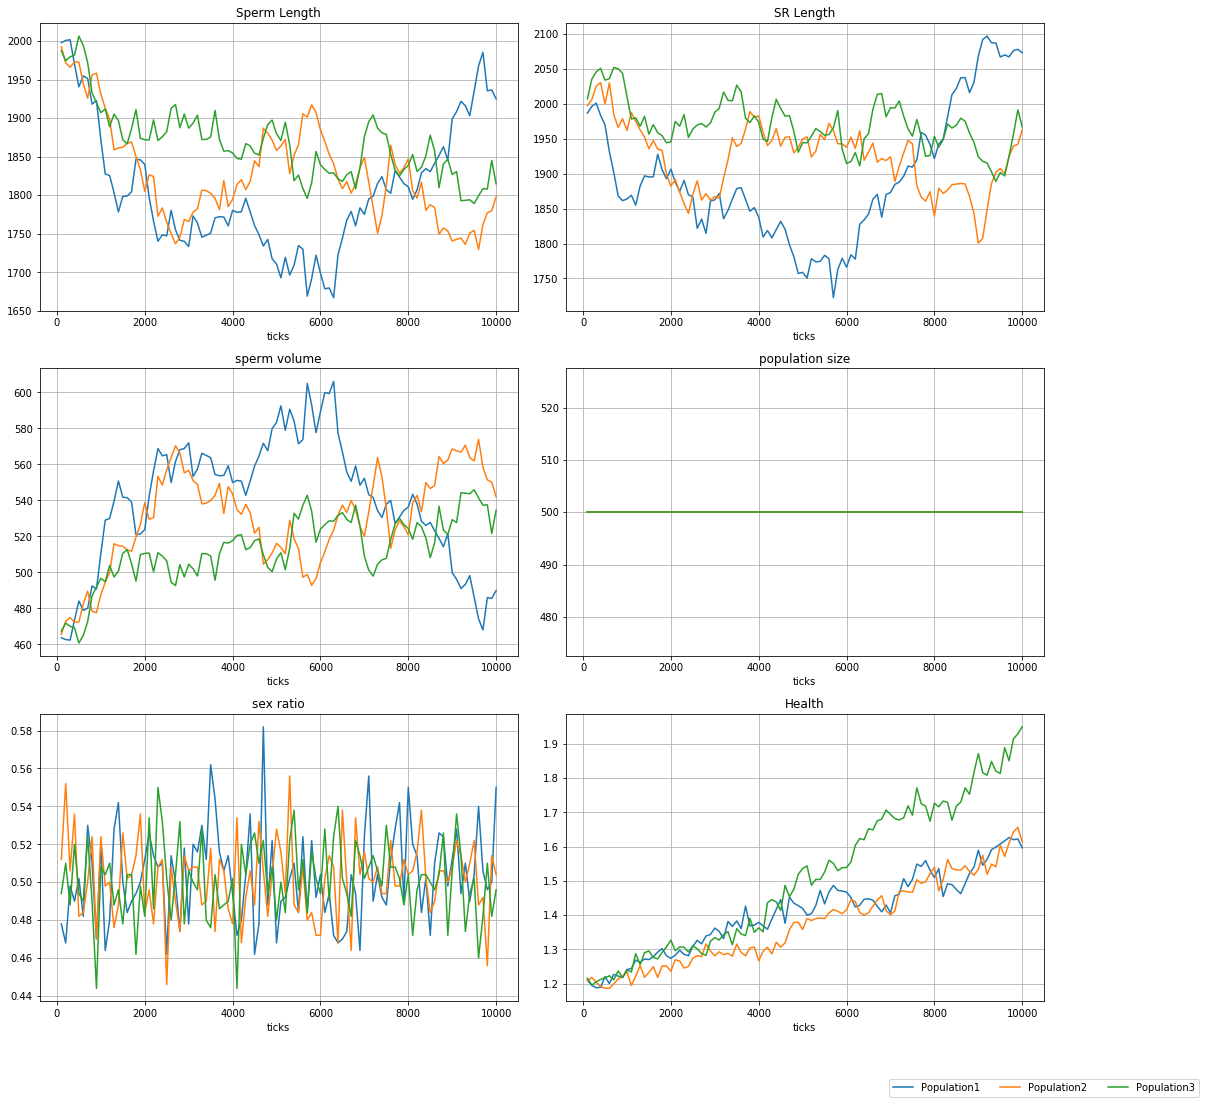

In [12]:
genome = [2000, 2000, 1] #spermlen, SRlen, health

#num, firstsize, genome, iteration, limit
for i in range(1):
    createpopulation(3, 100, genome, 10000, 500)


# SpermLen,SRLen の分散:60
# 環境分散:30